# Variational AutoEncoder

VAE model trained on MNIST dataset in order to generate handwritten digits. Latent dimension for σ and μ had the size of 2.

In [167]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, Conv2DTranspose, Flatten, Reshape, Lambda
from keras.datasets.mnist import load_data
from keras.metrics import Mean
from keras.losses import binary_crossentropy
import keras.backend as K
import numpy as np
import pickle as pkl
import tensorflow as tf
import os
from keras.models import load_model, Model
import matplotlib.pyplot as plt

tf.random.set_seed(2018)

In [83]:
class VAE(Model):
    
    def __init__(self,
                 inp_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_dim,
                 **kwargs):
        super(VAE, self).__init__(**kwargs)
        
        # check for proper config parameters
        if len(conv_filters) != len(conv_strides) or len(conv_filters) != len(conv_kernels):
            raise Exception('Length of conv_filters, conv_kernels, conv_strides must be equal')
            
        # store config parameters
        self.inp_shape = inp_shape
        self.conv_filters = conv_filters
        self.conv_kernels = conv_kernels
        self.conv_strides = conv_strides
        self.latent_dim = latent_dim
        
        # loss trackers
        self.tracker_total_loss = Mean(name='total_loss')
        self.tracker_kl_loss = Mean(name='kl_loss')
        self.tracker_reconstruction_loss = Mean(name='reconstruction_loss')
        
        # instantiate encoder and decoder models
        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()
        
        
        
    def train_step(self, X):
        
        # calculate under gradient tape
        with tf.GradientTape() as tape:
            mu, log_variance, z = self.encoder(X)
            X_hat = self.decoder(z)

            # calculate losses
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(binary_crossentropy(X, X_hat), axis=(1, 2)))
            kl_loss = -0.5 * (1 + log_variance - tf.square(mu) - tf.exp(log_variance))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = kl_loss + reconstruction_loss
            
        # compute gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        # apply gradients
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # update loss trackers
        self.tracker_reconstruction_loss.update_state(reconstruction_loss)
        self.tracker_kl_loss.update_state(kl_loss)
        self.tracker_total_loss.update_state(total_loss)
        
        return {
            "reconstruction_loss": self.tracker_reconstruction_loss.result(),
            "kl_loss": self.tracker_kl_loss.result(),
            "total_loss": self.tracker_total_loss.result()
        }
    
    
    
    @property
    def metrics(self):
        return [
             self.tracker_total_loss,
             self.tracker_kl_loss,
             self.tracker_reconstruction_loss 
        ]

    
        
    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        
        # save weights
        self.encoder.save_weights(os.path.join(path, 'encoder.h5'))
        self.decoder.save_weights(os.path.join(path, 'decoder.h5'))
        
        # save params 
        params = [
            self.inp_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_dim,
        ]
        with open(os.path.join(path, 'params.pkl'), 'wb') as file:
            pkl.dump(params, file)
            
            
            
    @classmethod
    def load(cls, path):
        with open(os.path.join(path, 'params.pkl'), 'rb') as file:
            params = pkl.load(file)
            
        model = VAE(*params)
        model.encoder.load_weights(os.path.join(path, 'encoder.h5'))
        model.decoder.load_weights(os.path.join(path, 'decoder.h5'))
        return model
        
        
        
    def _build_encoder(self):
        # sample from given distribution
        def sample_point(args):
            mu, log_variance = args
            batch = K.shape(mu)[0]
            dim = K.shape(mu)[1]
            epsilon = K.random_normal(shape=(batch, dim), mean=0.0, stddev=1.0)
            return mu + epsilon*K.exp(log_variance/2)
            
        # encoder architecture
        self.encoder_inp = Input(shape=self.inp_shape, name='enc_inp')
        x = self.encoder_inp

        for index in range(len(self.conv_filters)):
            x = self._add_conv_layer(index, x, 'conv2d')

        self.last_conv_dim = x.get_shape()[1:]
        x = Flatten(name='enc_flatten')(x)
        self.mu = Dense(units=self.latent_dim, name='mu')(x)
        self.log_variance = Dense(units=self.latent_dim, name='log_variance')(x)
        
        out = Lambda(sample_point, name='enc_out')([self.mu, self.log_variance])
        return Model(self.encoder_inp, [self.mu, self.log_variance, out], name='encoder')


    
    def _build_decoder(self):
        # decoder architecture
        inp = Input(shape=(self.latent_dim, ), name='dec_inp')
        x = inp
        
        x = Dense(units=np.prod(self.last_conv_dim), name='dec_dense')(x)
        x = Reshape(self.last_conv_dim, name='reshape')(x)

        for index in range(len(self.conv_filters)-1, -1, -1):
            x = self._add_conv_layer(index, x, 'conv2dT')

        out = Conv2D(self.inp_shape[-1], 1, activation='sigmoid', name='dec_out')(x)
        return Model(inp, out, name='decoder')

    

    def _add_conv_layer(self, index, last_layer, kind):
        if kind == 'conv2d':
            layer_num = index+1
            conv = Conv2D(
                filters=self.conv_filters[index],
                kernel_size=self.conv_kernels[index],
                strides=self.conv_strides[index],
                activation='relu',
                padding='same',
                name=f'conv_layer_{layer_num}'
            )
            
        elif kind == 'conv2dT':
            layer_num = len(self.conv_filters)-index
            conv = Conv2DTranspose(
                filters=self.conv_filters[index],
                kernel_size=self.conv_kernels[index],
                strides=self.conv_strides[index],
                activation='relu',
                padding='same',
                name=f'conv_layer_{layer_num}'
            )
            
        x = conv(last_layer)
        return BatchNormalization(name=f'conv_batchnorm_{layer_num}')(x)
    
    
    
vae = VAE(
    inp_shape=(28, 28, 1, ),
    conv_filters=(32, 64, 64, 64),
    conv_kernels=(3, 3, 3, 3),
    conv_strides=(1, 2, 2, 1),
    latent_dim=2  
)

# for visualization purposes
n_vae = VAE(
    inp_shape=(28, 28, 1, ),
    conv_filters=(32, 64, 64, 64),
    conv_kernels=(3, 3, 3, 3),
    conv_strides=(1, 2, 2, 1),
    latent_dim=2 
)
n_vae.compile(optimizer='adam')
vae.compile(optimizer='adam')

In [84]:
# load and preprocess MNIST
(x_train, y_train), (x_test, y_test) = load_data()

x_train = np.concatenate((x_train, x_test), axis=0)
y_train = np.concatenate((y_train, y_test), axis=0)
x_train = np.expand_dims(x_train, axis=-1)
x_train = x_train.astype('float32') / 255
x_train.shape

(70000, 28, 28, 1)

In [85]:
# trianed on google colab GPU
# vae.fit(x_train, epochs=20, batch_size=64)

In [86]:
vae = VAE.load('components')

In [168]:
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_inp (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv_layer_1 (Conv2D)           (None, 28, 28, 32)   320         enc_inp[0][0]                    
__________________________________________________________________________________________________
conv_batchnorm_1 (BatchNormaliz (None, 28, 28, 32)   128         conv_layer_1[0][0]               
__________________________________________________________________________________________________
conv_layer_2 (Conv2D)           (None, 14, 14, 64)   18496       conv_batchnorm_1[0][0]           
____________________________________________________________________________________________

In [169]:
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dec_inp (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dec_dense (Dense)            (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv_layer_1 (Conv2DTranspos (None, 7, 7, 64)          36928     
_________________________________________________________________
conv_batchnorm_1 (BatchNorma (None, 7, 7, 64)          256       
_________________________________________________________________
conv_layer_2 (Conv2DTranspos (None, 14, 14, 64)        36928     
_________________________________________________________________
conv_batchnorm_2 (BatchNorma (None, 14, 14, 64)        256 

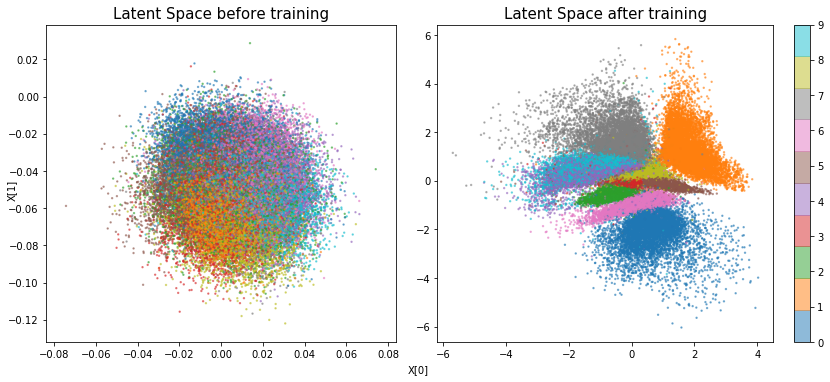

In [108]:
def plot_latent_points(vae, X, y, ax, colorbar=False, t='before'):
    points = vae.encoder.predict(X)[0]
    title = 'Latent Space ' + t + ' training'
    ax.set_title(title, size=15)
    im = ax.scatter(points[:, 0], points[:, 1], cmap='tab10', alpha=0.5, s=2, c=y)
    if colorbar:
        plt.colorbar(im, ax=ax)

        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1.2]})
fig.tight_layout()

plot_latent_points(n_vae, x_train, y_train, ax1, colorbar=False, t='before')
plot_latent_points(vae, x_train, y_train, ax2, colorbar=True, t='after')

fig.text(0.47, 0.0, 'X[0]', ha='center', va='center')
fig.text(0.0,  0.5, 'X[1]', ha='center', va='center', rotation='vertical')

plt.show()

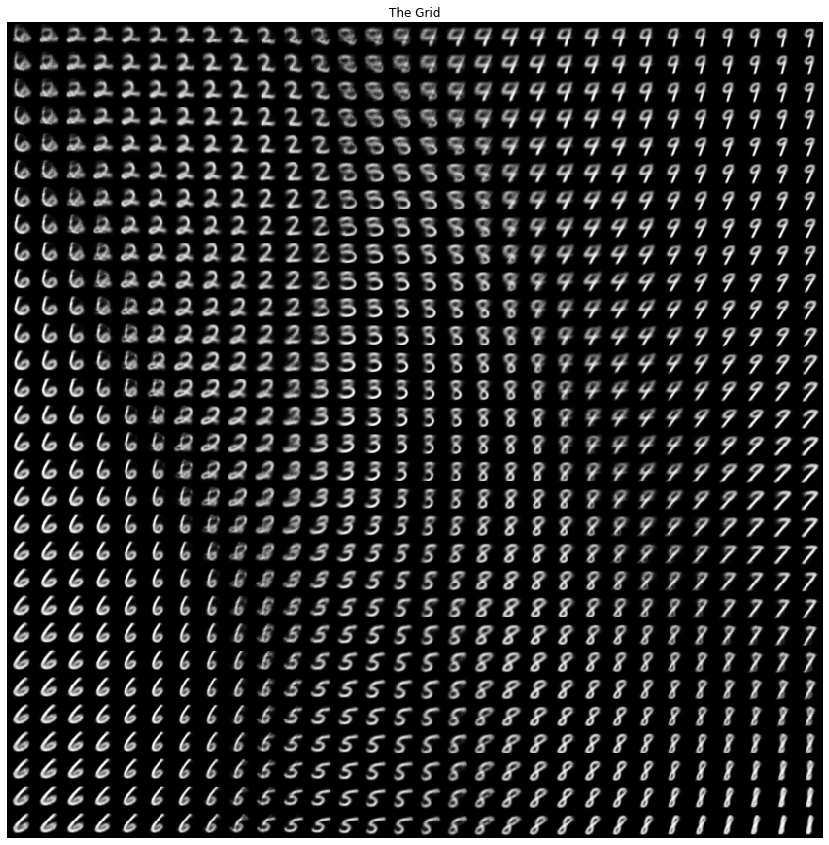

In [157]:
def plot_grid(vae, grid_size, boundary=(-1, 1)):
    # boundary is [-1, 1] since we can see from the plot above that
    # such space contains all of the digits and 
    # there is barely no great holes in it
    x = np.linspace(boundary[0], boundary[1], grid_size)
    y = np.linspace(boundary[0], boundary[1], grid_size)
    grid = np.zeros((grid_size*28, grid_size*28))
    
    for ix, vx in enumerate(x):
        for iy, vy in enumerate(y):
            img = vae.decoder.predict(np.array([[vx, vy]]))[0]
            img = np.squeeze(img, axis=-1)
            grid[ix*28:(ix+1)*28, 
                 iy*28:(iy+1)*28] = img
            
    plt.figure(figsize=(15, 15))
    plt.imshow(grid, cmap='gray')
    plt.title('The Grid')
    plt.axis('off')
    
    
plot_grid(vae, grid_size=30)